In [15]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats

##### How to compute NPM? 

The standardized Neighbour Pressure Metric is computed as follows: first, each dot (an individual language) is added to a graph where two languages are connected if they are within the trehsold distance *d* withing each-other. Then, the shortest path (if available) is computed for each pair of languages. Given one colexification, it's presence or absence in the languages of interest is recorded. The base NPM for an individual colexification and a language $l_j$ is then computed as the sum of $\frac{1}{4}^{d_i}$ (where $d_i$ is the distance from $l_j$ to $l_i$) for all of the languages reachable from $l_j$ in the graph if $l_j$ has this colexification. 

$\frac{1}{4}^{x}$ is used as it simulates the decay of the effect of one language on another as the distance between them increases. This decay is shaper than $\frac{1}{2}$ used in the original [paper](https://d1wqtxts1xzle7.cloudfront.net/63905290/LDC_009_01_005_s001_Nikolaev_proof-final20200713-96765-1np85zu-libre.pdf?1594632417=&response-content-disposition=inline%3B+filename%3DAreal_dependency_of_consonant_inventorie.pdf&Expires=1677084394&Signature=bofTV4YfEYPOsOKl4F1RKk-UnPGnUviIVh4SS3UVPvckr0v9ZXnmR4-tbULfpq1qnt6fU-sDwJcae78qlAxr7B1ODJtVmgt37IhygGfr9tX5v476grUVXOIV8XKj3mbC-uYA39PPABDGagAuo~xRZL33Yky2xeqvt42c~Vlc4KdNWLfp9OYekksxYs-4Hr0CSs1M2ntPa5VVYxaXQlCN~VyrvDlMEQb4jpZz6v84fy7jur1dnBa971cg~3hIQubAtCpfG5FBLqaZ7uNzNtpaOTHFzaOskdrvqwcXrGLbwsjDw8toB-r1E1JKstduEgyQArWvASoMmQxW7s1YuoayHA__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA). This function looks as follows:

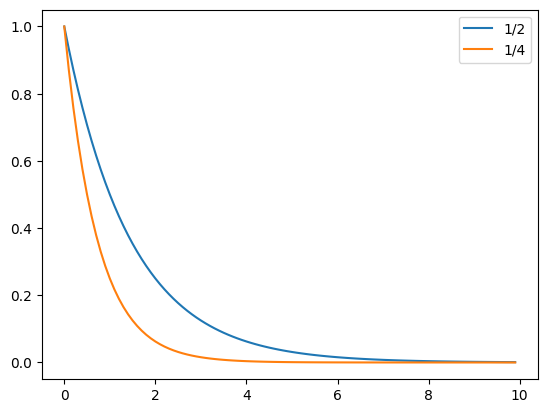

In [31]:
x = np.arange(0, 10, 0.1)
y = 1/2**x
y_ = 1/4**x
plt.plot(x, y, label='1/2')
plt.plot(x, y_, label='1/4')
plt.legend()

Then, the base NPM rate is divided by the maximum possible NPM, i.e. where $\frac{1}{4}^{d_i}$ is summed for all languages reachable from $l_j$ in the graph. This is done to normalize the NPM for each language and colexification. 

In [17]:
# def compute_NPM(G, node, labels):
#     npm = 0
    
#     p = dict(nx.shortest_path_length(G))
#     for j in p[node]:
#         if labels[j] == 1 and j != node:
#             npm += 1/4**p[j][node]
#     # compute maximum possible NPM
#     npm_max = 0
#     for j in p[node]:
#         if j != node:
#             npm_max += 1/4**p[j][node]
#     return npm/npm_max

def compute_NPM(G, node, labels):
    npm = 0
    
    p = dict(nx.shortest_path_length(G))
    for j in p[node]:
        if labels[j] == 1 and j != node:
            npm += 1/4**p[j][node]
    return npm

In [18]:
def random_graph(n=50, d=0.3, bin=True):
    # n = 50
    # d = 0.2
    x = np.random.uniform(0, 1, n)
    y = np.random.uniform(0, 1, n)
    # create a graph
    G = nx.Graph()
    # if the distance between two nodes is less than 0.2, add an edge
    for i in range(n):
            for j in range(i):
                if np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2) < d:
                    G.add_edge(i, j)
    
    # randomly generate binary labels for each node
    if bin:
        labels = np.random.binomial(1, 0.07, n)
    else:
        labels = np.zeros(n)
        for i in range(n):
            if x[i] < 0.3 and y[i] < 0.3:
                labels[i] = 1
    # color the nodes according to the labels (1 = red, 0 = blue)
    color_map = []
    for node in G:
        if labels[node] == 1:
            color_map.append('blue')
        else:
            color_map.append('red')
    return G, x, y, labels, color_map

# draw the graph

Let's look at an example. Suppose we have the following graph, where blue corresponds to having a colexification A, and red corresponds to not having a colexification A. In this case, all of the languages in the left bottom corner have this colexification, and all of the rest do not.

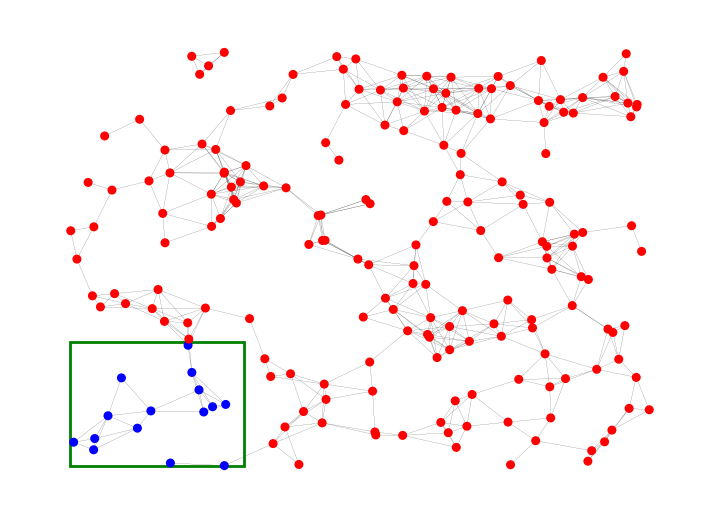

In [19]:
G, x, y, labels, color_map = random_graph(n=200, d=0.1, bin=False)
plt.figure(figsize=(7, 5))
nx.draw(G, pos = {i: (x[i], y[i]) for i in range(len(x))}, node_color = color_map, width = 0.1, node_size=30)
axis = plt.gca()
axis.add_patch(
    patches.Rectangle(
        xy=(0, 0),  # point of origin.
        width=0.3, height=0.3, linewidth=2,
        color='green', fill=False))

Let's compute NPM and plot the sizes of nodes as a function of their NPM value:

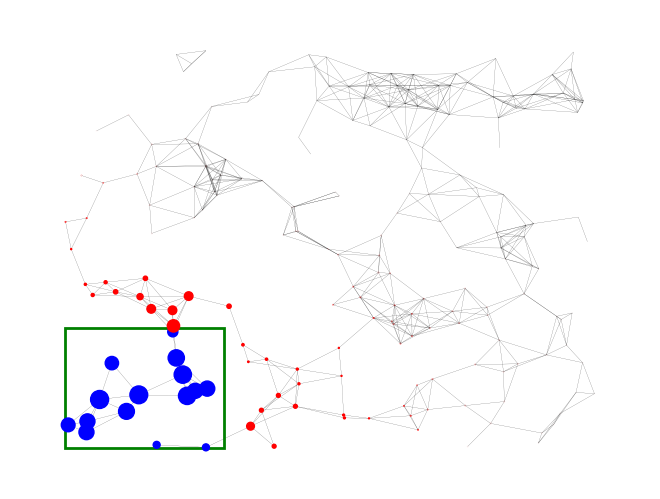

In [20]:
# plot g with npm as node size
npm = []
for i in G.nodes:
    npm.append(compute_NPM(G, i, labels))
nx.draw(G, pos = {i: (x[i], y[i]) for i in range(len(x))}, with_labels = False, node_color = color_map, node_size = [i*100 for i in npm], width = 0.1)
axis = plt.gca()
axis.add_patch(
    patches.Rectangle(
        xy=(0, 0),  # point of origin.
        width=0.3, height=0.3, linewidth=2,
        color='green', fill=False))

As shown on figure above, the NPM values are very large for blue-colored nodes, indicating that this metric can correctly identify the languages that have a colexification without any additional information. For instance, we do not check whether the language itself has this colexification and do not add it when computing the NPM. 

Let's consider the distribution of NPM values given presence (blue) or absence (red):

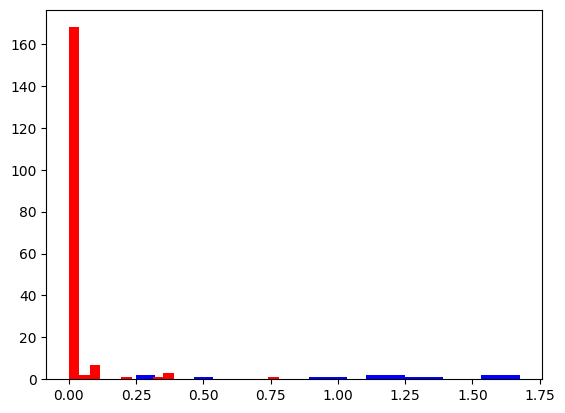

In [21]:
# plot distirbution of npm values for blue and red nodes

npm_blue = []
npm_red = []

for i in G.nodes:
    if labels[i] == 1:
        npm_blue.append(compute_NPM(G, i, labels))
    else:
        npm_red.append(compute_NPM(G, i, labels))
_ = plt.hist(npm_blue, color='blue', bins=20)
_ = plt.hist(npm_red, color='red', bins=20)

In [22]:
act_diff = np.mean(np.random.choice(npm_blue, 500) - np.random.choice(npm_red, 500))

act_diff

1.0728262028210793

In [23]:
sum(labels)/len(labels)

0.075

Let's consider an example where the presences/absenced are sampled at random from a binomial distribution with the parameter $p=0.3$:

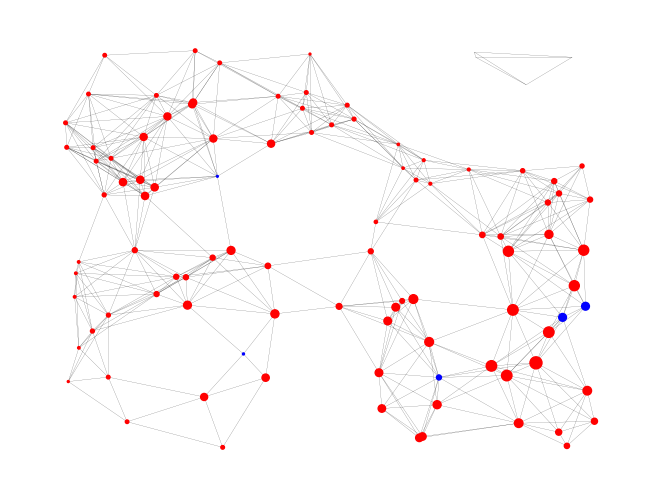

In [24]:
G, x, y, labels, color_map = random_graph(n=100, d=0.2, bin=True)
npm = []
for i in G.nodes:
    npm.append(compute_NPM(G, i, labels))
nx.draw(G, pos = {i: (x[i], y[i]) for i in range(len(x))}, with_labels = False, node_color = color_map, node_size = [i*100 for i in npm], width = 0.1)

Let's consider the distribution of the NPM values again. In this case, when no areal signal can be detected, they would intersect, as any language would be more or less equally likelly to have this colexification:

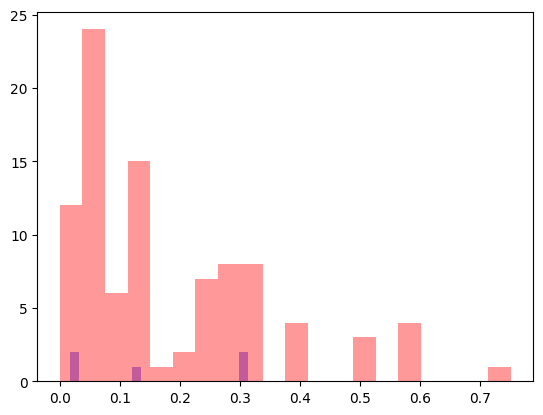

In [25]:
# plot distirbution of npm values for blue and red nodes

npm_blue = []
npm_red = []

for i in G.nodes:
    if labels[i] == 1:
        npm_blue.append(compute_NPM(G, i, labels))
    else:
        npm_red.append(compute_NPM(G, i, labels))
_ = plt.hist(npm_blue, color='blue', bins=20, alpha=0.4)
_ = plt.hist(npm_red, color='red', bins=20, alpha=0.4)

##### How to detect an areal signal using NPM?

One way of testing whether there is some areal signal is by plugging in the proportion from the real distribution into the binomial distribution, and sampling randomized labels from there. Then, we can subtract the NPM for presence and absence for random samples n times and compare the results with the real difference.  

In [26]:
# difference  
diff = []

for _ in range(100):
    G, x, y, labels, color_map = random_graph(n=100, d=0.2, bin=True)
    npm_blue = []
    npm_red = []
    for i in G.nodes:
        if labels[i] == 1:
            npm_blue.append(compute_NPM(G, i, labels))
        else:
            npm_red.append(compute_NPM(G, i, labels))
    # subtract blue from red by randomly drawing values, repeat 500 times
    diff.append(np.mean(np.random.choice(npm_blue, 500) - np.random.choice(npm_red, 500)))

An illustration of 100 samples:

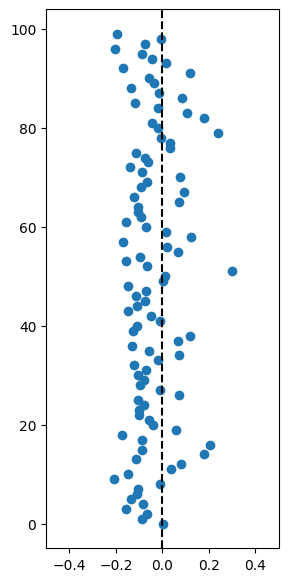

In [27]:
# plot diff vs run ID 

plt.figure(figsize=(3, 7))
plt.scatter(diff, range(len(diff)))

plt.xlim(-0.5, 0.5)
# add a vertical line at 0
plt.axvline(x=0, color='black', linestyle='--')

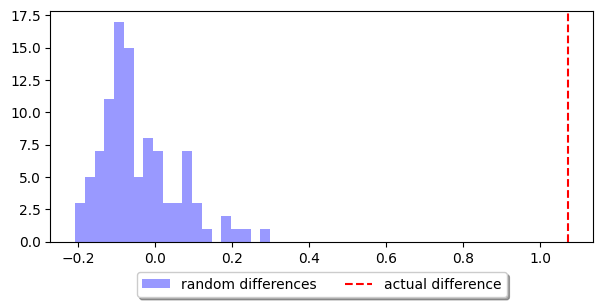

In [28]:
# plot diff and actual_diff
plt.figure(figsize=(7, 3))
plt.hist(diff, color='blue', bins=20, alpha=0.4, label='random differences')
plt.axvline(x=act_diff, color='red', linestyle='--', label='actual difference')
# plt.xlim(-0.1, 1)

plt.legend()
# legend on the bottom of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)